In [54]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import random



In [55]:
# Kaydedilmiş modeli yüklemek
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Veri setini yüklemek
df = pd.read_csv("Training.csv")

# Sütun isimlerini almak
feature_names = df.columns[:-2]  # Son sütun hedef değişken olduğunu varsayıyoruz ve onu dahil etmiyoruz

# Modelin özellik önemlerini yüklemek
feature_importances = model.feature_importances_

# Özellik önemlerini sıralamak
sorted_indices = feature_importances.argsort()[::-1]


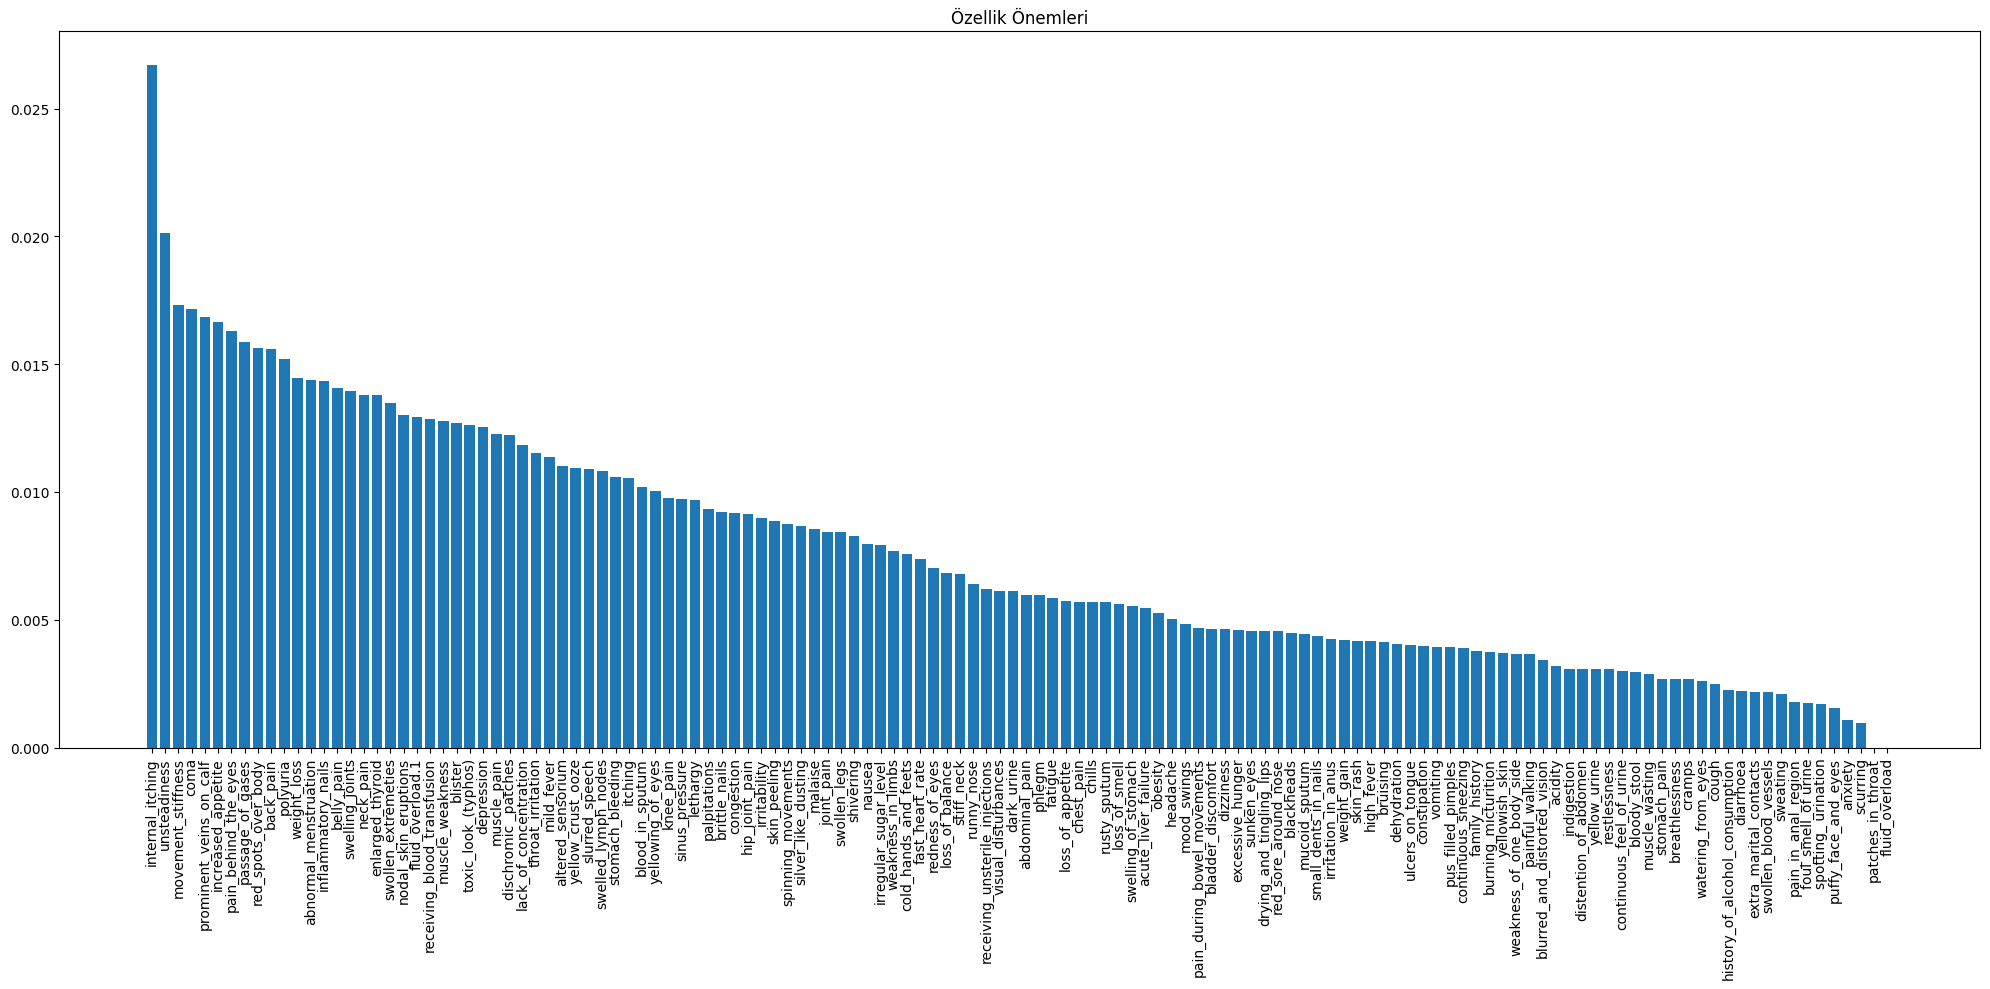

In [56]:

# Görselleştirme
plt.figure(figsize=(20, 10))
plt.title("Özellik Önemleri")
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [61]:
# Modelin özellik önemlerini kullanarak en önemli özelliklerin sıralı listesini oluşturma
top_features = sorted(zip(feature_importances, feature_names), reverse=True)

# En önemli özellikleri (belirtileri) sıralı bir liste halinde saklama
sorted_features = [feature for importance, feature in top_features]

# Bu liste, soru sıralamasını oluşturmak için kullanılacak
# Örnek: ['ateş', 'öksürük', 'halsizlik', ...]


In [67]:

# Rastgele bir başlangıç belirtisi seçmek
initial_symptom = random.choice(sorted_features)

def ask_symptoms_and_predict(model, feature_names, sorted_features, belirtiler_ceviri, threshold=0.3):
    user_symptoms = {symptom: 0 for symptom in sorted_features}  # Tüm belirtileri başlangıçta 0 olarak ayarla
    symptoms_asked = []

    while True:
        # Rastgele belirti seçmek
        next_symptom = random.choice([f for f in sorted_features if f not in symptoms_asked])
        next_symptom_tr = belirtiler_ceviri.get(next_symptom, next_symptom)

        # Kullanıcıya bu belirtiyi sor
        response = input(f"{next_symptom_tr} var mı? (Evet/Hayır): ").strip().lower()
        user_symptoms[next_symptom] = 1 if response == 'evet' else 0
        symptoms_asked.append(next_symptom)

        # Şu ana kadar toplanan bilgilerle tahmin yapma
        input_features = [user_symptoms[feature] for feature in feature_names]
        input_array = np.array(input_features).reshape(1, -1)
        probabilities = model.predict_proba(input_array)[0]
        max_prob = max(probabilities)

        # Mevcut tahmin gücünü ve hedefi yazdır
        print(f"Mevcut tahmin güveni: {max_prob:.2f}, Belirlenen eşik: {threshold}")

        # Yeterli tahmin gücüne ulaşıldı mı kontrol et
        if max_prob >= threshold or len(symptoms_asked) >= len(sorted_features):
            break

    predicted_disease_index = np.argmax(probabilities)
    return predicted_disease_index, max_prob, user_symptoms



def make_prediction(user_symptoms, model, feature_names, threshold):
    input_features = [user_symptoms[feature] for feature in feature_names]
    input_array = np.array(input_features).reshape(1, -1)

    probabilities = model.predict_proba(input_array)[0]
    max_prob = max(probabilities)

    if max_prob >= threshold:
        predicted_disease_index = np.argmax(probabilities)
        return predicted_disease_index, max_prob
    else:
        return None, max_prob




# JSON dosyalarını yüklemek
with open('hastaliklar_ceviri.json', 'r', encoding='utf-8') as file:
    hastaliklar_ceviri = json.load(file)

with open('belirtiler_ceviri.json', 'r', encoding='utf-8') as file:
    belirtiler_ceviri = json.load(file)
 
predicted_disease_index, confidence, user_symptoms = ask_symptoms_and_predict(model, feature_names, sorted_features, belirtiler_ceviri, threshold=0.3)

if confidence >= 0.3:
    predicted_disease = model.classes_[predicted_disease_index]
    predicted_disease_tr = hastaliklar_ceviri.get(predicted_disease, "Bilinmeyen Hastalık")
    print(f"Tahmini hastalık: {predicted_disease_tr}, Güven: {confidence:.2f}")
else:
    print("Yeterli bilgi yok.")




Yeterli bilgi yok.


c:\Users\hbsamur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [59]:
# Hastalıkların çevirilerini içeren JSON dosyasını yükleyip bir sözlüğe dönüştürme
with open('hastaliklar_ceviri.json', 'r', encoding='utf-8') as file:
    hastaliklar_ceviri = json.load(file)

# JSON dosyasını yükleyip bir sözlüğe dönüştürme
with open('belirtiler_ceviri.json', 'r', encoding='utf-8') as file:
    belirtiler_ceviri = json.load(file)


# Testing.csv dosyasını yükleyin
testing_df = pd.read_csv('Testing.csv')

# Benzersiz hastalık isimlerini alın
unique_diseases = testing_df['prognosis'].unique()

# Modelin sınıf etiketlerini alın
model_classes = model.classes_

# Benzersiz hastalık isimlerini modelin sınıf etiketleri ile eşleştirin
disease_to_class = dict(zip(model_classes, unique_diseases))

def get_user_symptoms_and_predict(sorted_features, model, feature_names, disease_to_class, hastaliklar_ceviri, threshold=0.3):
    random.shuffle(sorted_features)  # Soruların sırasını karıştır
    user_symptoms = {}
    for feature in sorted_features:
        turkish_feature = belirtiler_ceviri.get(feature, feature)
        response = input(f"{turkish_feature} var mı? (Evet/Hayır): ").lower()
        user_symptoms[feature] = 1 if response == 'evet' else 0

        input_features = [user_symptoms.get(feature, 0) for feature in feature_names]
        input_array = np.array(input_features).reshape(1, -1)

        probabilities = model.predict_proba(input_array)[0]
        max_prob = max(probabilities)
        print(f"Mevcut tahmin güveni: {max_prob:.2f}, Belirlenen eşik: {threshold}")

        if max_prob >= threshold:
            predicted_disease_index = np.argmax(probabilities)
            predicted_disease_english = disease_to_class[model_classes[predicted_disease_index]]
            predicted_disease_turkish = hastaliklar_ceviri.get(predicted_disease_english, predicted_disease_english)
            return predicted_disease_turkish, max_prob

    return "Belirsiz", max(probabilities)

# Tahmini yapmak için fonksiyonu çağır
predicted_disease, confidence = get_user_symptoms_and_predict(sorted_features, model, feature_names, disease_to_class, hastaliklar_ceviri)
print(f"Tahmini hastalık: {predicted_disease}, Güven: {confidence:.2f}")


c:\Users\hbsamur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Mevcut tahmin güveni: 0.04, Belirlenen eşik: 0.3


c:\Users\hbsamur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Mevcut tahmin güveni: 0.04, Belirlenen eşik: 0.3


KeyboardInterrupt: Interrupted by user